In [ ]:
from io import BytesIO, StringIO
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_poisson_deviance
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor,plot_importance
from sklearn.tree import DecisionTreeClassifier

# parameter tuning
from itertools import product
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
url='https://drive.google.com/file/d/1K9DgN4kznwJOimZD6i3iUfVn2icfdFBX/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(dwn_url)
df.head()

,ct_key,rent.ct,grrent_yield.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,...,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,...,0.239304,0.035645,0.033135,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437
1,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,...,0.067753,0.033413,0.029529,0.024965,0.024260,0.012650,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513
2,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,...,0.020936,-0.018518,-0.013602,-0.029572,-0.030480,0.006510,0.501407,0.675439,0.168421,0.090175,0.029825,0.016140,0.020000,41738,47163,30506,48359,53658,38016,0.576155,0.423845,10.2,13.7,1904,3.92,1.59,2.98,0.595016,0.213396,0.176012,0.000000,0.000000,0.0,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824
3,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,...,0.055119,0.007368,0.001279,0.010184,0.015024,0.016664,0.444160,0.733766,0.152597,0.078283,0.005411,0.021284,0.008658,50483,52450,30114,60798,67342,41587,0.688275,0.311725,17.8,14.2,1774,4.42,1.35,3.51,0.363333,0.526667,0.086667,0.015556,0.007778,0.0,0.000000,43.6,18.4,37.9,0.757377,223400.0,0.027945
4,8001008100,2203.0,10.072085,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,1

In [ ]:
url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
listings = pd.read_csv(dwn_url)
listings.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09


In [ ]:
# preprocess listing dataset
listings['ct_key'] = listings['ct_key'].astype('int')
listings['sale_month'] = pd.to_datetime(listings['sale_date'])+ pd.offsets.MonthBegin(0)
listings['list_month'] = pd.to_datetime(listings['list_date'])+ pd.offsets.MonthBegin(0)

In [ ]:
# by census tract
num_listings_ct = listings.dropna(subset=['list_month']).groupby(['ct_key', 'list_month']).count()[['property_id']].reset_index()
num_listings_ct = num_listings_ct.rename(columns={'property_id':'ct_count_listings', 'list_month':'month'})

num_sales_ct = listings.dropna(subset=['sale_month']).groupby(['ct_key', 'sale_month']).count()[['property_id']].reset_index()
num_sales_ct = num_sales_ct.rename(columns={'property_id':'ct_count_sales', 'sale_month':'month'})

num_sales_listings = pd.merge(num_listings_ct, num_sales_ct, left_on=['month','ct_key'], right_on=['month','ct_key'], how='outer')
num_sales_listings = num_sales_listings.fillna(0.)
num_sales_listings

,ct_key,month,ct_count_listings,ct_count_sales
0,8001007801,2016-04-01,3.0,3.0
1,8001007801,2016-05-01,4.0,1.0
2,8001007801,2016-06-01,3.0,2.0
3,8001007801,2016-07-01,5.0,2.0
4,8001007801,2016-08-01,1.0,2.0
...,...,...,...,...
42050,8123002300,2020-04-01,0.0,1.0
42051,8123002501,2016-07-01,0.0,1.0
42052,8123002501,2018-05-01,0.0,1.0
42053,8125963200,2016-12-01,0.0,1.0


In [ ]:
df_merged = pd.merge(df, num_sales_listings, left_on='ct_key', right_on='ct_key')
print(df_merged.shape)

listing_sales_overall = df_merged.groupby(['ct_key','month']).agg({'ct_count_listings':'mean', 'ct_count_sales':'mean', 'total_households':'mean'}).reset_index()
listing_sales_overall = listing_sales_overall.groupby('month').agg({'ct_count_listings':'sum', 'ct_count_sales':'sum', 'total_households':'sum'})

listing_sales_overall['sales_per_households'] = listing_sales_overall['ct_count_sales']/listing_sales_overall['total_households']
listing_sales_overall['listings_per_households'] = listing_sales_overall['ct_count_listings']/listing_sales_overall['total_households']
# display(listing_sales_overall.head())

df_merged = pd.merge(df_merged, listing_sales_overall[['sales_per_households', 'listings_per_households']], left_on='month', right_index=True)
df_merged['ct_listings_per_households'] = df_merged['ct_count_listings']/df_merged['total_households']
df_merged['ct_sales_per_households'] = df_merged['ct_count_sales']/df_merged['total_households']

df_merged['relative_listings_toBaseline'] = df_merged['ct_listings_per_households']/df_merged['listings_per_households']
df_merged['relative_sales_toBaseline'] = df_merged['ct_sales_per_households']/df_merged['sales_per_households']
df_merged.head()


(41734, 112)


,ct_key,rent.ct,grrent_yield.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,...,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,...,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,2016-04-01,3.0,3.0,0.003984,0.009716,0.002344,0.002344,0.241238,0.588276
54,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.0,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,...,0.160594,0.012464,0.009108,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,2016-04-01,4.0,1.0,0.003984,0.009716,0.002768,0.000692,0.284922,0.173701
105,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,34.526095,65.473905,0.0,5.882353,82.335231,46.875042,81.712204,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,...,0.090175,0.029825,0.016140,0.020000,41738,47163,30506,48359,53658,38016,0.576155,0.423845,10.2,13.7,1904,3.92,1.59,2.98,0.595016,0.213396,0.176012,0.000000,0.000000,0.0,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824,2016-04-01,15.0,7.0,0.003984,0.009716,0.007878,0.003676,0.810884,0.922786
162,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,51.528767,48.471233,0.0,2.794521,66.152493,27.052337,79.212530,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,...,0.078283,0.005411,0.021284,0.008658,50483,52450,30114,60798,67342,41587,0.688275,0.311725,17.8,14.2,1774,4.42,1.35,3.51,0.363333,0.526667,0.086667,0.015556,0.007778,0.0,0.000000,43.6,18.4,37.9,0.757377,223400.0,0.027945,2016-04-01,11.0,7.0,0.003984,0.009716,0.006201,0.003946,0.638225,0.990408
220,8001008200,2190.0,9.419278,100.0,3255.950515,41.0,21.0,0.0,49.0,59.0,0.850785,18.390052,80.759162,0.000000,95.811518,1.570681,0.000000,2.617801,0.000000,0.000000,2.617801,5.824607,35.863874,33.7696

In [ ]:
# check columns with null
df_merged.columns[df_merged.isnull().any()]

Index([], dtype='object')

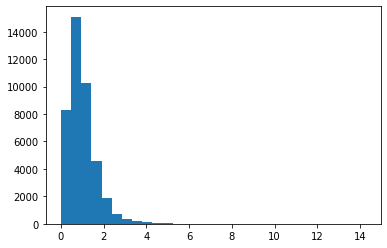

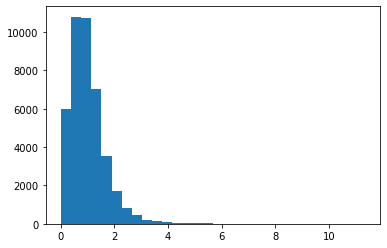

In [ ]:
plt.hist(df_merged['relative_listings_toBaseline'], bins=30)
plt.show()

plt.hist(df_merged['relative_sales_toBaseline'], bins=30)
plt.show()

Predict Num of Listings

Predict Num of Sales

In [ ]:
X = df_merged.drop(['ct_key', 'pop_density.ct', 'census_population', 'month','ct_count_listings', 'ct_count_sales', 'sales_per_households', 'listings_per_households', 
                     'ct_listings_per_households', 'ct_sales_per_households', 'relative_listings_toBaseline','relative_sales_toBaseline'], axis=1)
X.columns = X.columns.str.replace(">","greaterthan").str.replace("<","lessthan")

y = df_merged['relative_sales_toBaseline'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
display(X_train_normalized.head())

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

,rent.ct,grrent_yield.ct,frm.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,pt_violent.ct,pt_property.ct,...,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,lessthan200k,200-300k,300-400k,400-500k,500-750k,750-1000k,greaterthan1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate
3512,0.179676,0.758624,1.0,0.177083,0.000000,0.540541,0.802326,0.822917,0.345706,0.555855,0.083046,0.024498,0.207531,0.000000,0.022284,0.053744,0.926419,0.012688,0.023834,0.331888,0.696812,0.313277,0.014130,0.765236,0.234764,0.000000,0.104195,0.641504,0.559857,0.896852,0.933244,0.914202,0.719383,0.226570,0.574340,0.468595,0.343451,0.074686,0.132499,0.023582,...,0.034389,0.494471,0.439669,0.534387,0.559682,0.169846,0.538161,0.726924,0.542838,0.181673,0.088760,0.082414,0.014820,0.125251,0.101766,0.067638,0.116005,0.087581,0.132203,0.750035,0.249965,0.239865,0.201905,0.302171,0.697761,0.181818,0.644231,0.322004,0.166369,0.812676,0.074013,0.000000,0.000000,0.000000,0.491337,0.429752,0.337004,0.315789,0.031408,0.104195
36211,0.514973,0.549927,1.0,0.458333,0.341772,0.000000,0.488372,0.541667,0.276903,0.696551,0.023439,0.006770,0.563367,0.295323,0.055427,0.230163,0.029244,0.075739,0.171637,0.306577,0.365002,0.510113,0.112098,0.683967,0.316033,0.082005,0.084805,0.330345,1.000000,0.205473,0.111450,0.556626,0.529807,0.182615,0.525196,0.586795,0.330728,0.069517,0.031514,0.009031,...,0.080924,0.214243,0.231190,0.389272,0.439875,0.236080,0.482551,0.826275,0.262703,0.078471,0.000000,0.363781,0.061821,0.269496,0.363658,0.125089,0.203761,0.199005,0.293252,0.613536,0.386464,0.435811,0.222857,0.108717,0.380597,0.079545,0.352564,0.013657,0.125948,0.952092,0.481326,0.070266,0.033831,0.000000,0.698020,0.417355,0.159692,0.592427,0.184224,0.084805
25049,0.288169,0.304897,1.0,0.531250,0.430380,0.000000,0.406977,0.468750,0.754068,0.238276,0.005762,0.008137,0.560340,0.108436,0.067623,0.361261,0.000000,0.117691,0.318796,0.314644,0.494479,0.189700,0.069872,0.548431,0.451569,0.006951,0.086295,0.673791,0.191204,0.571968,0.867111,0.512793,0.646310,0.257902,0.569242,0.485447,0.282834,0.083453,0.142287,0.024020,...,0.293749,0.828269,0.663413,0.961954,0.854542,0.409779,0.608511,0.882592,0.285276,0.073192,0.028790,0.099653,0.104561,0.195908,0.189249,0.187054,0.144214,0.104430,0.274193,0.651188,0.348812,0.209459,0.175238,0.445075,0.690299,0.136364,0.573718,0.188575,0.512285,0.354861,0.181525,0.000000,0.000000,0.000000,0.495050,0.295455,0.405286,0.887373,0.120740,0.086295
27690,0.329651,0.200725,1.0,0.281250,0.126582,0.270270,0.686047,0.718750,0.739207,0.265400,0.000000,0.000000,0.022018,0.476937,0.320654,0.615196,0.000000,0.077896,0.352384,0.735193,0.277368,0.000000,0.000000,0.443969,0.556031,0.008413,0.077828,0.724530,1.000000,0.113265,0.293769,0.268006,0.329049,0.341668,0.618068,0.246697,0.346581,0.200501,0.098987,0.012093,...,0.419797,0.793481,0.686572,0.769958,0.793485,0.263905,0.782608,0.784154,0.175908,0.114928,0.148977,0.236123,0.124604,0.285610,0.358309,0.196706,0.195993,0.187786,0.326682,0.511431,0.488569,0.527027,0.331429,0.110985,0.134328,0.102273,0.198718,0.000000,0.174009

In [ ]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)

(33387, 106)
(8347, 106)


In [ ]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

y_mean = np.mean(y_train)
y_median = np.median(y_train)

space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'max_depth': hp.quniform("max_depth", 4, 9, 1),
    'n_estimators': hp.quniform('n_estimators', 250, 750, 50),
    'min_child_weight': 1.12,
    'colsample_bytree': 0.62,
    'colsample_bylevel': 0.7,
    'objective':'reg:squarederror',
    # 'eval_metric':'poisson-nloglik',
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha' : hp.quniform('reg_alpha', 5,20,1),
    'base_score': y_median
}

def hyperparameter_tuning(space):
    model = XGBRegressor(learning_rate = space['learning_rate'],
                         n_estimators = int(space['n_estimators']), 
                         max_depth = int(space['max_depth']), 
                         min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'],
                         colsample_bylevel = space['colsample_bylevel'],
                         objective = space['objective'],
                        #  eval_metric = space['eval_metric'],
                         reg_lambda = space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']), 
                         base_score = space['base_score']
                         )
    
    evaluation = [(X_train_normalized, y_train), (X_test_normalized, y_test)]
    
    model.fit(X_train_normalized, y_train, eval_set=evaluation, eval_metric="mae", early_stopping_rounds=5, verbose=False)

    pred = model.predict(X_test_normalized)
    error= mean_poisson_deviance(y_test, pred)
    print("SCORE:", error)

    return {'loss':error, 'status': STATUS_OK, 'model': model}


In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

SCORE:
0.27598692179552137
SCORE:
0.3114716187928607
SCORE:
0.24352821393235843
SCORE:
0.2511005511447256
SCORE:
0.29845237707399314
SCORE:
0.2820433121152157
SCORE:
0.24792792609525702
SCORE:
0.2851533687433925
SCORE:
0.274040308724689
SCORE:
0.2873708477710195
SCORE:
0.34449126486820797
SCORE:
0.2634583592459444
SCORE:
0.24224011510338264
SCORE:
0.29390129392701425
SCORE:
0.2575749325299748
SCORE:
0.3649660731661543
SCORE:
0.291082882593796
SCORE:
0.28423672750080825
SCORE:
0.30778054433643887
SCORE:
0.31453148120612323
SCORE:
0.2516792102826515
SCORE:
0.2403527579043672
SCORE:
0.24029477507229868
SCORE:
0.24031346604154874
SCORE:
0.2402364973324234
SCORE:
0.24319130045551066
SCORE:
0.2402405691521517
SCORE:
0.24145466297049864
SCORE:
0.2438976126119607
SCORE:
0.24785694336537187
SCORE:
0.26054767565144593
SCORE:
0.24451096936529607
SCORE:
0.2470454690814771
SCORE:
0.24320598903932453
SCORE:
0.2693480922940071
SCORE:
0.24140805221827483
SCORE:
0.24475031831839378
SCORE:
0.25194206808

In [ ]:
# best = {'learning_rate': 0.00845722617800218, 'max_depth': 9.0, 'n_estimators': 700.0, 'reg_alpha': 6.0, 'reg_lambda': 0.8880978094678765}
print(best)

{'learning_rate': 0.00845722617800218, 'max_depth': 9.0, 'n_estimators': 700.0, 'reg_alpha': 6.0, 'reg_lambda': 0.8880978094678765}


In [ ]:
 #'best' gives the learning rate, max_depth, n_estimators, alpha, lambda
final_model = XGBRegressor(learning_rate = best['learning_rate'], 
                           max_depth = int(best['max_depth']),
                           n_estimators = int(best['n_estimators']),
                           reg_alpha = int(best['reg_alpha']),
                           reg_lambda = best['reg_lambda'],
                           base_score = space['base_score'], 
                           min_child_weight = space['min_child_weight'], 
                           colsample_bytree = space['colsample_bytree'],
                           colsample_bylevel = space['colsample_bylevel'],
                           objective = space['objective'],
                           eval_metric = 'poisson-nloglik')
print(final_model)
final_model.fit(X_train_normalized,y_train)
print(mean_poisson_deviance(y_train, final_model.predict(X_train_normalized)))
print(mean_poisson_deviance(y_test, final_model.predict(X_test_normalized)))

XGBRegressor(base_score=0.8918212550403493, booster='gbtree',
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.62,
             eval_metric='poisson-nloglik', gamma=0, importance_type='gain',
             learning_rate=0.00845722617800218, max_delta_step=0, max_depth=9,
             min_child_weight=1.12, missing=None, n_estimators=700, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=6, reg_lambda=0.8880978094678765, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
0.233268784778882
0.24016599344905487


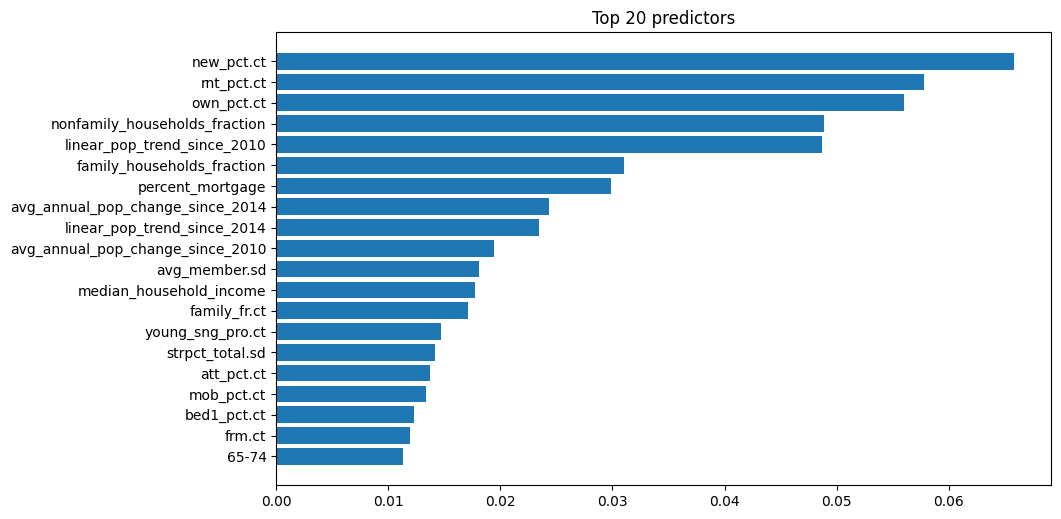

In [ ]:
fig, ax = plt.subplots(1,1, dpi=100,figsize=(10,6))
sorted_idx = final_model.feature_importances_.argsort()[::-1][:20]
ax.barh(np.arange(20), final_model.feature_importances_[sorted_idx][::-1])
ax.set_yticks(np.arange(20))
ax.set_yticklabels([col for col in X_train_normalized.columns[sorted_idx]][::-1])
ax.set_title("Top 20 predictors")
plt.show()

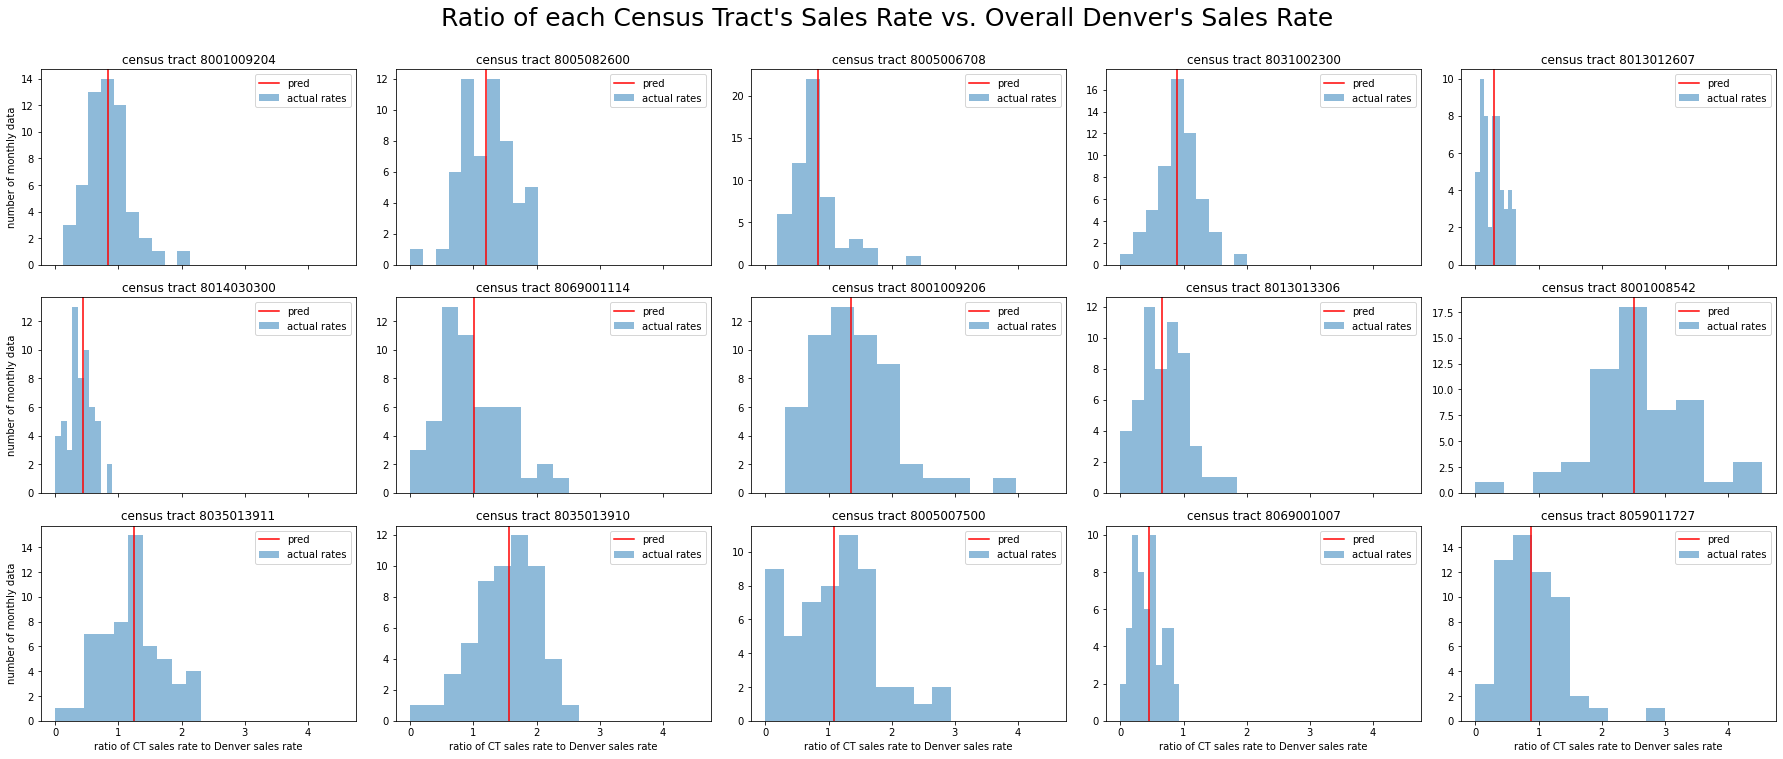

In [ ]:
# take 25 random test points, and plot the predicted rate of sales/households (compared to the distributions of known rate)
np.random.seed(100)
random_test_idx = np.random.choice(X_test_normalized.index, 15, replace=False)
df_test_pred = df_merged.loc[random_test_idx]
df_test_pred['pred_sales'] = final_model.predict(X_test_normalized.loc[random_test_idx])

fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Sales Rate vs. Overall Denver's Sales Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(df_test_pred.ct_key.unique()):
  ax[idx//5, idx%5].set_title(f"census tract {ct}")

  # plot the distribution of known rates
  ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'], alpha=0.5, label='actual rates')
  # ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline']), c='k', linestyle=':', label='mean ratio')

  # plot the prediction
  pred = df_test_pred[df_test_pred['ct_key']==ct]['pred_sales'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='r',label='pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()

  # axis label
  if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT sales rate to Denver sales rate")
  if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")

plt.tight_layout()

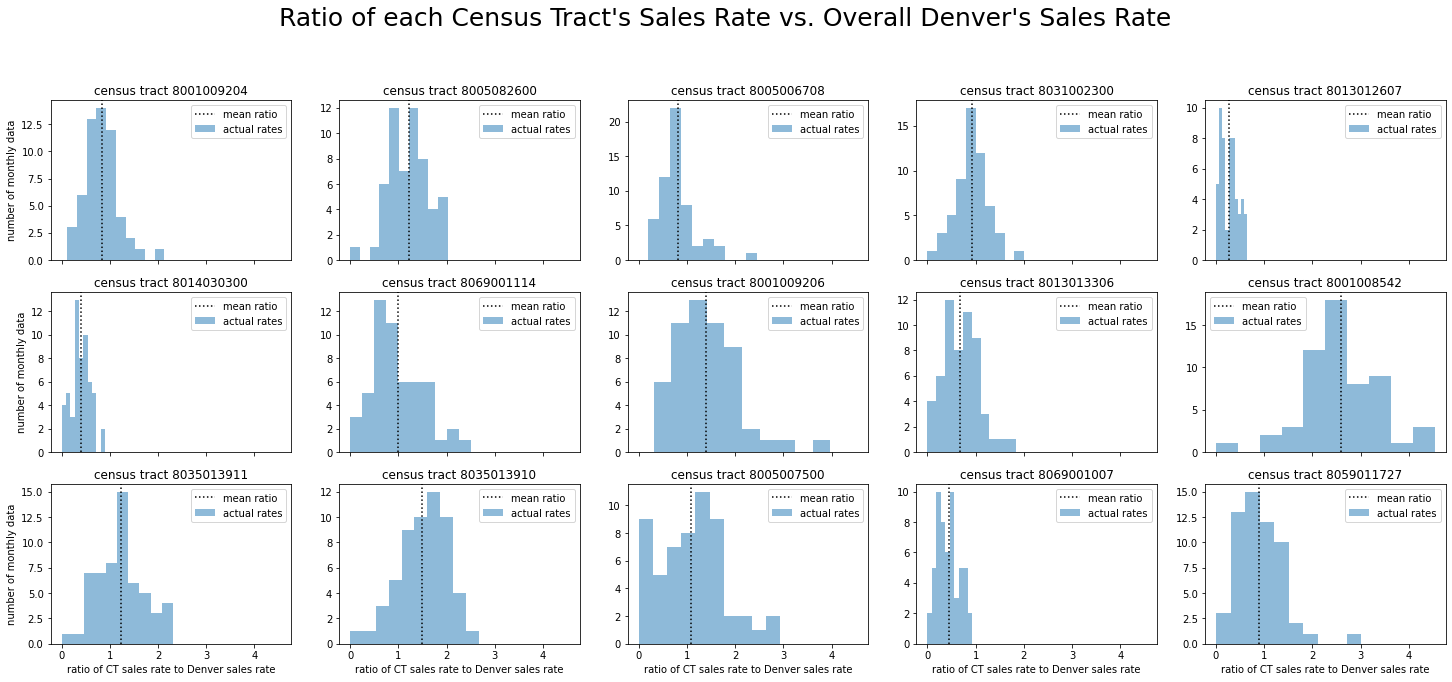

In [ ]:
# plot without the prediction
fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Sales Rate vs. Overall Denver's Sales Rate", fontsize=25, y=1.01)
for idx, ct in enumerate(df_test_pred.ct_key.unique()):
  ax[idx//5, idx%5].set_title(f"census tract {ct}")

  # plot the distribution of known rates
  ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'], alpha=0.5, label='actual rates')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline']), c='k', linestyle=':', label='mean ratio')
  
  ax[idx//5, idx%5].legend()
  # axis label
  if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT sales rate to Denver sales rate")
  if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")
